In [16]:
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pycox.datasets import metabric
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold

In [2]:
s = 1

#### METABRIC

<b> Pycox (Time-to-Event Prediction with Neural Networks and Cox Regression): </b>
    
data -> cv + val
cv - 5 folds stratified by y and time bin

hp search:
    for every cv fold:
        fit on all cv folds except this fold
        save quality on val
select the best parameters by val quality

train and evaluate model with best parameters in 5fold CV (train on 4, test on one) - out average


As the four data sets are somewhat small, we scored our fitted models using 5-fold cross-
validation, where the hyperparameter search was performed individually for each fold. For
all the neural networks, we performed a random hyperparameter search over 300 parameter
configurations and chose the model with the best score on a held-out validation set.
we sample 300 random parameter configurations for each method,
for each fold of each data set
Table 2 shows the time-dependent concordance, or C td , averaged over the five cross-
validation folds.

In [3]:
df_all = metabric.read_df()

In [4]:
df_all.describe()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,duration,event
count,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000
mean,6.210830,6.237199,10.765366,5.872822,0.616597,0.597164,0.207983,0.758929,61.087112,125.025055,0.579307
std,0.862968,1.020872,1.357359,0.341254,0.486344,0.490591,0.405970,0.427844,12.978707,76.334206,0.493800
min,5.158794,4.860645,6.372949,5.101093,0.000000,0.000000,0.000000,0.000000,21.930000,0.000000,0.000000
25%,5.692096,5.408728,9.969681,5.622290,0.000000,0.000000,0.000000,1.000000,51.375001,60.824999,0.000000
50%,5.949283,5.877591,10.530301,5.816998,1.000000,1.000000,0.000000,1.000000,61.769999,114.900002,1.000000
75%,6.458780,6.899220,11.159306,6.058293,1.000000,1.000000,0.000000,1.000000,70.592497,184.474995,1.000000
max,14.443632,9.932116,14.643900,7.658863,1.000000,1.000000,1.000000,1.000000,96.290001,355.200012,1.000000


In [7]:
df_all = df_all[df_all['duration'] != 0]

In [8]:
cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

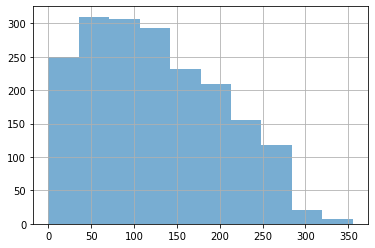

In [9]:
df_all['duration'].hist(alpha=0.6);

In [10]:
quan = np.arange(0, 1, 0.2)
bins = df_all['duration'].quantile(quan).values
bins = np.append(bins, np.inf)
df_all['duration_bin'] = pd.cut(df_all['duration'], bins=bins, labels=np.arange(0, 5, 1))
df_all['strata'] = df_all['event'].astype(str) + "_" + df_all['duration_bin'].astype(int).astype(str)

/home/islam/anaconda3/envs/pycox/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/islam/anaconda3/envs/pycox/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [11]:
df_all['strata'].value_counts(dropna=False).sort_index()

0_0                        45
0_1                       110
0_2                       181
0_3                       211
0_4                       253
1_-9223372036854775808      1
1_0                       335
1_1                       270
1_2                       200
1_3                       170
1_4                       127
Name: strata, dtype: int64

In [12]:
df_all = df_all[df_all['strata'] != '1_-9223372036854775808']

In [13]:
df_all['strata'].value_counts(dropna=False).sort_index()

0_0     45
0_1    110
0_2    181
0_3    211
0_4    253
1_0    335
1_1    270
1_2    200
1_3    170
1_4    127
Name: strata, dtype: int64

In [14]:
# get validation data
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1)
df_all.reset_index(drop=True, inplace=True)
for tr_i, te_i in sss.split(df_all, df_all['strata']):
    # split
    df_val = df_all.iloc[te_i, ]
    df_cv = df_all.iloc[tr_i, ]
    # preprocess val
    m = df_cv[cols_standardize].mean()
    v = df_cv[cols_standardize].std()
    df_val_tr = df_val.copy(deep=True)
    for idx, col in enumerate(cols_standardize):
        df_val_tr[col] = df_val_tr[col] - m.values[idx]
        df_val_tr[col] = df_val_tr[col] / v.values[idx]
    x_val = df_val_tr[cols_standardize + cols_leave].values
    y_val = df_val_tr['event'].values
    t_val = df_val_tr['duration'].astype(int).values

In [15]:
# get cv data
df_cv_data = dict()
df_cv.reset_index(drop=True, inplace=True)
sf = StratifiedKFold(n_splits=5, random_state=1)
for i, (tr_i, te_i) in enumerate(sf.split(df_cv, df_cv['strata'])):
    # split
    df_train = df_cv.iloc[tr_i, ]
    df_test = df_cv.iloc[te_i, ]
    # preprocess
    m = df_train[cols_standardize].mean()
    v = df_train[cols_standardize].std()
    for idx, col in enumerate(cols_standardize):
        df_train[col] = df_train[col] - m.values[idx]
        df_train[col] = df_train[col] / v.values[idx]
        df_test[col] = df_test[col] - m.values[idx]
        df_test[col] = df_test[col] / v.values[idx]
    df_cv_data[i] = {
        'test': {
            'x': df_test[cols_standardize + cols_leave].values,
            'y': df_test['event'].values,
            't': df_test['duration'].astype(int).values 
        },
        'train': {
            'x': df_train[cols_standardize + cols_leave].values,
            'y': df_train['event'].values,
            't': df_train['duration'].astype(int).values 
        }
    }

/home/islam/anaconda3/envs/pycox/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/islam/anaconda3/envs/pycox/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/islam/anaconda3/envs/pycox/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [16]:
data = {
    'val': {
        'x': x_val,
        'y': y_val,
        't': t_val
    },
    'cv': df_cv_data
}

with open('../data/metabric_cv.pkl', 'wb') as f:
    pickle.dump(data, f)

### KKBOX

- split on train-test-val by client
- select parameters on val
- and also report results on test with selected parameters
- how to get: pycox_examples/01_introduction_save_data.ipynb

<b> Pycox (Time-to-Event Prediction with Neural Networks and Cox Regression): </b>
    
data -> train - test - val

select hyperparameters with the help of val

report results on test when each model if fitted 5 times on train


In [23]:
from pycox.datasets import kkbox_v1

In [119]:
df_train = kkbox_v1.read_df(subset='train')
df_train.shape

(1786333, 18)

In [120]:
df_train.sample(10)

,msno,event,n_prev_churns,log_days_between_subs,duration,log_days_since_reg_init,log_payment_plan_days,log_plan_list_price,log_actual_amount_paid,is_auto_renew,is_cancel,city,gender,registered_via,age_at_start,strange_age,nan_days_since_reg_init,no_prev_churns
1338502,juBAwNSe6LXGdAj4/HPVq+S0PZB5RY2iNyVWH0C3w/M=,1.0,0.0,0.0,700.0,6.280396,3.433987,5.010635,5.010635,0.0,0.0,13,female,9,20.0,0.0,0.0,1.0
192119,4pS3kmRE1QP2ETx1Z7qinGIErXqiXVasfSyy7hwX07o=,0.0,0.0,0.0,180.0,6.583409,3.433987,4.605170,4.605170,1.0,0.0,1,NaN,7,-0.0,1.0,0.0,1.0
834324,RrLUN/704wV253moeuhkuTtJaDA95C0Hr1oGA9eNv4k=,1.0,0.0,0.0,136.0,0.693147,3.433987,5.010635,5.010635,1.0,0.0,1,NaN,7,0.0,1.0,0.0,1.0
766477,PPtTLp1bv67nWBoOSv/n+ZVMRYz5xiv5v9cWDC5nC2c=,1.0,0.0,0.0,231.0,4.976734,3.465736,5.010635,5.010635,1.0,0.0,14,male,3,24.0,0.0,0.0,1.0
684670,MU8OBTrgEDkmDx3a75PJWqXQV6zfwJVfXMX/CuUIpIM=,1.0,0.0,0.0,104.0,4.330733,3.433987,5.010635,5.010635,0.0,0.0,1,NaN,9,0.0,1.0,0.0,1.0
1312527,iz0HBr+zN83g29TC6FCOKWVDjxnWZ5RSnCsgkLnL3P8=,1.0,0.0,0.0,203.0,5.690359,3.433987,4.867534,4.867534,1.0,0.0,8,male,4,25.0,0.0,0.0,1.0
987132,XK7ya7SMlJFX32Xh6dHU1umxDSIER5dlTc5vdycCVJ4=,1.0,0.0,0.0,247.0,0.693147,0.000000,0.000000,4.867534,1.0,0.0,1,NaN,7,0.0,1.0,0.0,1.0
1674399,vx7XuEfd8CBcEkP9OccN8SOqhfgkTRzERax2/KIR4C4=,0.0,0.0,0.0,790.0,7.247793,3.433987,5.010635,5.010635,1.0,0.0,1,NaN,7,0.0,1.0,0.0,1.0
713387,NWV9+VAv+EePRlQyQW2FR9CthyAFwHWDXApGRPPxl/U=,1.0,2.0,0.0,48.0,6.620073,2.397895,0.000000,0.000000,0.0,0.0,15,female,3,26.0,0.0,0.0,0.0
923582,V2+YKPp1Nkn+u5BfBOBPzeo9DvFWGvisIRHPJCU2RjQ=,1.0,0.0,0.0,175.0,6.192362,3.433987,5.010635,5.010635,0.0,0.0,5,male,7,14.0,0.0,0.0,1.0


In [105]:
df_test = kkbox_v1.read_df(subset='test')
df_test.shape

(661748, 18)

In [106]:
df_val = kkbox_v1.read_df(subset='val')
df_val.shape

(198665, 18)

In [107]:
print("Zero duration in train: ", df_train[df_train['duration'] == 0].shape)
print("Zero duration in test: ", df_test[df_test['duration'] == 0].shape)
print("Zero duration in val: ", df_val[df_val['duration'] == 0].shape)

Zero duration in train:  (0, 18)
Zero duration in test:  (0, 18)
Zero duration in val:  (0, 18)


In [108]:
df_train.describe()

,event,n_prev_churns,log_days_between_subs,duration,log_days_since_reg_init,log_payment_plan_days,log_plan_list_price,log_actual_amount_paid,is_auto_renew,is_cancel,age_at_start,strange_age,nan_days_since_reg_init,no_prev_churns
count,1.786333e+06,1.786333e+06,1.786333e+06,1.786333e+06,1.786333e+06,1.786333e+06,1.786333e+06,1.786333e+06,1.786333e+06,1.786333e+06,1.786333e+06,1.786333e+06,1.786333e+06,1.786333e+06
mean,7.161923e-01,1.543900e-01,2.993105e-01,2.285690e+02,4.207446e+00,3.150953e+00,3.868665e+00,3.549763e+00,5.549358e-01,7.635755e-03,1.212652e+01,3.980977e-01,1.624440e-01,8.852555e-01
std,4.520748e-01,4.908541e-01,1.146079e+00,2.526903e+02,3.036363e+00,1.044879e+00,2.234905e+00,2.405540e+00,4.964042e-01,8.673631e-02,1.536644e+01,4.898612e-01,3.709731e-01,3.203050e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,2.900000e+01,6.931472e-01,3.433987e+00,4.605170e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
50%,1.000000e+00,0.000000e+00,0.000000e+00,1.010000e+02,5.420535e+00,3.433987e+00,5.010635e+00,5.010635e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.000000e+00,0.000000e+00,0.000000e+00,4.100000e+02,6.919684e+00,3.433987e+00,5.010635e+00,5.010635e+00,1.000000e+00,0.000000e+00,2.500000e+01,1.000000e+00,0.000000e+00,1.000000e+00
max,1.000000e+00,7.000000e+00,6.559615e+00,8.200000e+02,8.459140e+00,6.111467e+00,7.601402e+00,7.601402e+00,1.000000e+00,1.000000e+00,1.000000e+02,1.000000e+00,1.000000e+00,1.000000e+00


In [109]:
t = df_train['duration']
y = df_train['event'].astype(int)
binary_cols = ['is_auto_renew', 'is_cancel', 'strange_age', 'nan_days_since_reg_init', 'no_prev_churns']
batchnorm_cols = ['n_prev_churns', 'log_days_between_subs', 'log_days_since_reg_init', 'log_payment_plan_days', 'log_plan_list_price',
                  'log_actual_amount_paid', 'age_at_start']
cat_cols = ['city', 'gender', 'registered_via']

In [110]:
print("There are {} binary cols".format(len(binary_cols)))
print("There are {} continous cols".format(len(batchnorm_cols)))

There are 5 binary cols
There are 7 continous cols


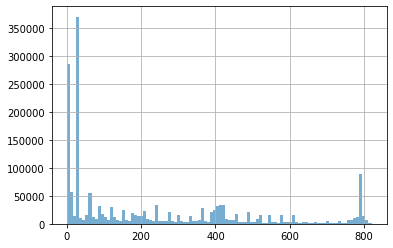

In [111]:
df_train['duration'].hist(alpha=0.6, bins=100);

In [160]:
pd.concat([df_train['city'], df_test['city'], df_val['city']], axis=0).value_counts(dropna=False)

1.0     1002197
NaN      430310
13.0     259864
5.0      209847
4.0      139727
15.0     122656
22.0     121784
6.0       75349
14.0      55590
9.0       42039
12.0      36379
11.0      25636
8.0       23826
18.0      22563
10.0      19396
21.0      16898
17.0      15214
3.0       14914
7.0        7080
16.0       2842
20.0       2131
19.0        504
Name: city, dtype: int64

In [159]:
df_train['city'].nunique()

21

In [122]:
df_train['city'].value_counts(dropna=False)

1.0     676807
NaN     290179
13.0    175368
5.0     141680
4.0      94268
15.0     82972
22.0     82092
6.0      51016
14.0     37313
9.0      28305
12.0     24527
11.0     17252
8.0      16071
18.0     15249
10.0     13020
21.0     11333
17.0     10243
3.0      10140
7.0       4761
16.0      1951
20.0      1436
19.0       350
Name: city, dtype: int64

In [35]:
df_train['gender'].value_counts(dropna=False)

NaN       990574
male      419392
female    376367
Name: gender, dtype: int64

In [46]:
gender_map = {
    'male': 1,
    'female': 2
}
df_train['gender'].astype(str).map(gender_map).fillna(0).value_counts(dropna=False)

0.0    990574
1.0    419392
2.0    376367
Name: gender, dtype: int64

In [79]:
registered_via_cats = pd.concat([df_train['registered_via'], df_test['registered_via'], df_val['registered_via']]).astype(str)
registered_via_cats = reversed(sorted(registered_via_cats.unique().tolist()))
registered_via_cats_map = {cat: i for i, cat in enumerate(registered_via_cats)}
registered_via_cats_map

{'nan': 0,
 '9.0': 1,
 '7.0': 2,
 '4.0': 3,
 '3.0': 4,
 '16.0': 5,
 '13.0': 6,
 '10.0': 7}

In [80]:
df_val['registered_via'].astype(str).map(registered_via_cats_map).value_counts(dropna=False)

1    57340
2    52195
4    36077
0    32339
3    20420
6      294
Name: registered_via, dtype: int64

In [177]:
def preprocess_kkbox(df):
    
    def get_one_hot_encoded(values, cat_series):
        out_array = np.zeros((cat_series.shape[0], len(values)))
        for val in values:
            out_array[:, val] = (cat_series == val).astype(int)
        return out_array

    df1 = df.copy(deep=True)
    # target
    t = df['duration'].astype(int).values
    y = df['event'].astype(int).values
    # work with cat features
    df1['city'] = df['city'].astype(str).astype(float).fillna(0).astype(int)
    gender_map = {
        'male': 1,
        'female': 2
    }
    df1['gender'] = df['gender'].astype(str).map(gender_map).fillna(0).astype(int)    
    registered_via_cats_map = {
        'nan': 0,
        '9.0': 1,
        '7.0': 2,
        '4.0': 3,
        '3.0': 4,
        '16.0': 5,
        '13.0': 6,
        '10.0': 7
    }
    df1['registered_via'] = df['registered_via'].astype(str).map(registered_via_cats_map)
    # categories to one-hot
    gender_values = [0, 1, 2]
    city_values = np.arange(23) # 23 unique values
    registered_via_values = np.arange(8) # 8 unique values
    gender_ = get_one_hot_encoded(gender_values, df1['gender'])
    city_ = get_one_hot_encoded(city_values, df1['city'])
    registered_via_values_ = get_one_hot_encoded(registered_via_values, df1['registered_via'])  
    # binary cols as is
    binary_cols = ['is_auto_renew', 'is_cancel', 'strange_age', 'nan_days_since_reg_init', 'no_prev_churns'] 
    binary_ = df1[binary_cols].values
    # continous cols  - apply batchnorm in network
    batchnorm_cols = ['n_prev_churns', 'log_days_between_subs', 'log_days_since_reg_init', 'log_payment_plan_days', 'log_plan_list_price',
                      'log_actual_amount_paid', 'age_at_start']
    batchnorm_ = df1[batchnorm_cols].values
    # final features
    x = np.hstack([gender_, city_, registered_via_values_, binary_, batchnorm_])
    return x, t, y

In [178]:
x, t, y = preprocess_kkbox(df_train)

In [92]:
# remove outliers?
# https://towardsdatascience.com/enhancing-categorical-features-with-entity-embeddings-e6850a5e34ff